In [42]:
import functools

import ase
from ase.visualize import view

import jax
import jax.numpy as jnp

import numpy as np
import seaborn as sns

import flax
import flax.linen as nn
import optax
from clu import metrics

import matplotlib.pyplot as plt

from molnet.data import input_pipeline_online
from molnet.models import create_model
from molnet import train_state
from molnet import loss

from configs import attention_unet
from configs import root_dirs

from typing import Any, Dict, Tuple, Callable

In [70]:
config = attention_unet.get_config()
config.batch_size = 4
config.interpolate_input_z = None
config.z_cutoff = 1.0
config.gaussian_factor = 5.0
config.train_molecules = (0, 80000)
config.val_molecules = (80000, 100000)
#config.train_molecules = (0, 50000)
#config.val_molecules = (50000, 60000)
config.root_dir = root_dirs.get_root_dir("afms_rebias")

@flax.struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output("loss") # type: ignore

In [71]:
ds = input_pipeline_online.get_datasets(config)
rng = jax.random.PRNGKey(0)
init_rng, rng = jax.random.split(rng)

model = create_model(config.model)
dummy_input = next(ds['train'])
print(f"input shape: {dummy_input['images'].shape}")
print(f"atom map shape: {dummy_input['atom_map'].shape}")
variables = model.init(init_rng, dummy_input["images"], training=False)
params = variables["params"]
batch_stats = variables["batch_stats"]

loss_fn = loss.get_loss_function(config.loss_fn)
tx = optax.adam(learning_rate=3e-4)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 18085879115725111131
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11891891844372152216
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing 

input shape: (4, 128, 128, 10, 1)
atom map shape: (4, 128, 128, 10, 5)


In [72]:
train_metrics = Metrics.empty()

state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    batch_stats=batch_stats,
    tx=tx,
    best_params=params,
    step_for_best_params=0,
    metrics_for_best_params={},
)

In [73]:
@functools.partial(jax.jit, static_argnums=(2,))
def train_step(
    state: train_state.TrainState,
    batch: Dict[str, Any],
    loss_fn: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]
) -> Tuple[train_state.TrainState, metrics.Collection]:
    """Train step."""

    def loss_wrapper(params):
        preds, updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            batch["images"],
            training=True,
            mutable='batch_stats',
        )
        total_loss = loss_fn(
            preds,
            batch["atom_map"]
        )
        #mean_loss = jnp.mean(total_loss)

        return total_loss, (preds, updates)

    # Compute loss and gradients
    grad_fn = jax.value_and_grad(loss_wrapper, has_aux=True)
    (batch_loss, (_, updates)), grads = grad_fn(state.params)

    batch_metrics = Metrics.single_from_model_output(
        loss=batch_loss,
    )

    # Update parameters
    new_state = state.apply_gradients(
        grads=grads,
        batch_stats=updates["batch_stats"]
    )

    return new_state, batch_metrics


In [74]:
@functools.partial(jax.jit)
def pred_batch(
    state: train_state.TrainState,
    batch: Dict[str, Any],
) -> jnp.ndarray:
    preds = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        batch["images"],
        training=False,
    )
    return preds

In [75]:
train_metrics = Metrics.empty()
for i in range(2000):
    batch = next(ds['train'])
    state, batch_metrics = train_step(state, batch, loss_fn)
    train_metrics = train_metrics.merge(batch_metrics)
    if i % 10 == 0:
        train_metrics = train_metrics.compute()
        print(f"step {i}, loss: {train_metrics}")
        train_metrics = Metrics.empty()

step 0, loss: {'loss': Array(0.8782508, dtype=float32)}
step 10, loss: {'loss': Array(0.15007363, dtype=float32)}
step 20, loss: {'loss': Array(0.02499132, dtype=float32)}
step 30, loss: {'loss': Array(0.01742281, dtype=float32)}
step 40, loss: {'loss': Array(0.01104809, dtype=float32)}
step 50, loss: {'loss': Array(0.01191024, dtype=float32)}
step 60, loss: {'loss': Array(0.00951855, dtype=float32)}
step 70, loss: {'loss': Array(0.01018661, dtype=float32)}
step 80, loss: {'loss': Array(0.00775861, dtype=float32)}
step 90, loss: {'loss': Array(0.00875497, dtype=float32)}
step 100, loss: {'loss': Array(0.0086012, dtype=float32)}
step 110, loss: {'loss': Array(0.00698732, dtype=float32)}
step 120, loss: {'loss': Array(0.00720452, dtype=float32)}
step 130, loss: {'loss': Array(0.00672864, dtype=float32)}
step 140, loss: {'loss': Array(0.00876132, dtype=float32)}
step 150, loss: {'loss': Array(0.00889199, dtype=float32)}
step 160, loss: {'loss': Array(0.00648665, dtype=float32)}
step 170, 

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 9711585323322707358
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 11082840322387386371
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing t

step 1270, loss: {'loss': Array(0.00579061, dtype=float32)}
step 1280, loss: {'loss': Array(0.00650918, dtype=float32)}
step 1290, loss: {'loss': Array(0.00636246, dtype=float32)}
step 1300, loss: {'loss': Array(0.00735092, dtype=float32)}
step 1310, loss: {'loss': Array(0.00710845, dtype=float32)}
step 1320, loss: {'loss': Array(0.00585437, dtype=float32)}
step 1330, loss: {'loss': Array(0.00677988, dtype=float32)}
step 1340, loss: {'loss': Array(0.00416701, dtype=float32)}
step 1350, loss: {'loss': Array(0.00568115, dtype=float32)}
step 1360, loss: {'loss': Array(0.00482023, dtype=float32)}
step 1370, loss: {'loss': Array(0.00655351, dtype=float32)}
step 1380, loss: {'loss': Array(0.00484395, dtype=float32)}
step 1390, loss: {'loss': Array(0.00417179, dtype=float32)}
step 1400, loss: {'loss': Array(0.00492165, dtype=float32)}
step 1410, loss: {'loss': Array(0.00597952, dtype=float32)}
step 1420, loss: {'loss': Array(0.00647208, dtype=float32)}
step 1430, loss: {'loss': Array(0.005404

In [76]:
batch = next(ds['val'])
y = pred_batch(state, batch)
idx = 1
y0 = y[idx]
ref = batch["atom_map"][idx]
print(f"ref min/max: {ref.min()}, {ref.max()}")
x0 = batch["images"][idx]

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 10083096188548548466
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 562762232596408869
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing te

ref min/max: 0.0, 4.8698883056640625


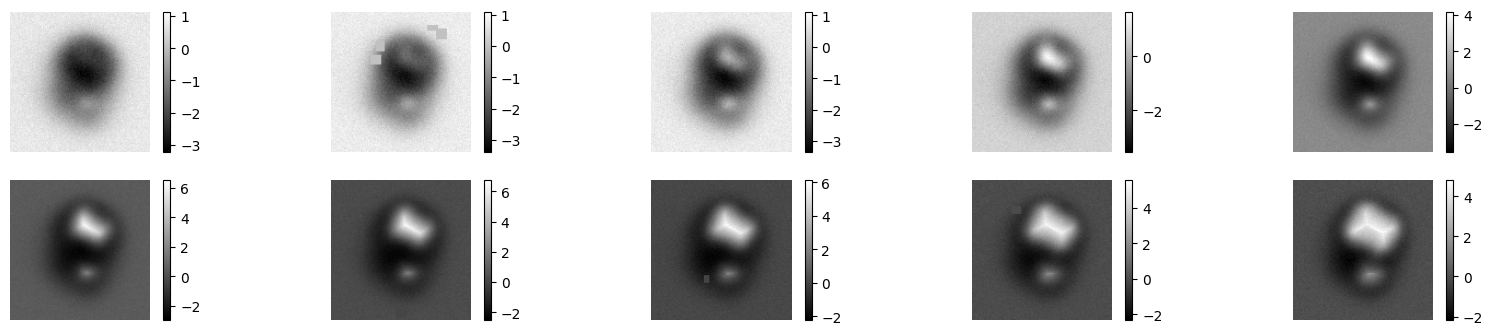

In [77]:
fig = plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    im = ax.imshow(x0[..., i, 0], cmap='gray', origin='lower')
    plt.colorbar(im)

    ax.axis('off')


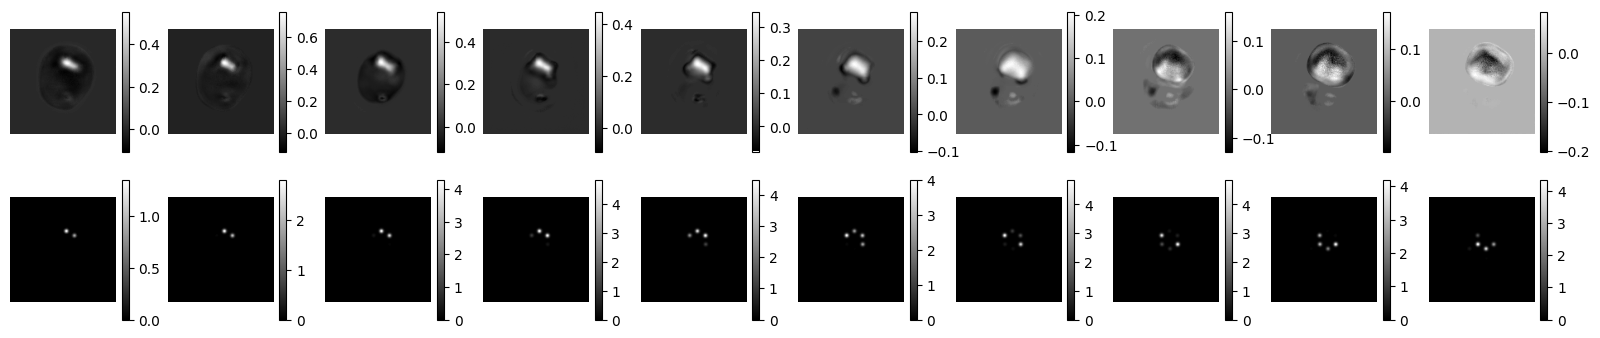

In [78]:
channel = 1

fig = plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    im = ax.imshow(y0[..., i, channel], cmap='gray', origin='lower',)
    plt.colorbar(im)
    ax.axis('off')

    ax = plt.subplot(2, 10, i+11)
    im = ax.imshow(ref[..., i, channel], cmap='gray', origin='lower')
    plt.colorbar(im)
    ax.axis('off')



In [14]:
xyz = batch["xyz"][idx]
mol = ase.Atoms(positions=xyz[:, :3], numbers=xyz[:, -1])
view(mol)

<Popen: returncode: None args: ['/u/79/kurkil1/unix/.venvs/tf-2.13/bin/pytho...>

In [79]:
def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = 5
    rows = int(np.ceil(len(val_dict)/columns))
    fig, ax = plt.subplots(rows, columns, figsize=(5*columns, 4*rows))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index//columns, fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

def visualize_gradients(state, params, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    # Pass one batch through the network, and calculate the gradients for the weights
    def loss_func(params):
        preds, _ = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            batch["images"],
            training=True,
            mutable='batch_stats',
        )
        total_loss = loss_fn(
            preds,
            batch["atom_map"]
        )
        #mean_loss = jnp.mean(total_loss)

        return total_loss
    grads = jax.grad(loss_func)(params)
    grads = jax.device_get(grads)
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = jax.tree_util.tree_leaves(grads)
    grads = [g.reshape(-1) for g in grads if len(g.shape) > 1]
    grads = {f'Layer {layer_idx*2}': g for layer_idx, g in enumerate(grads)}

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    fig.tight_layout()
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

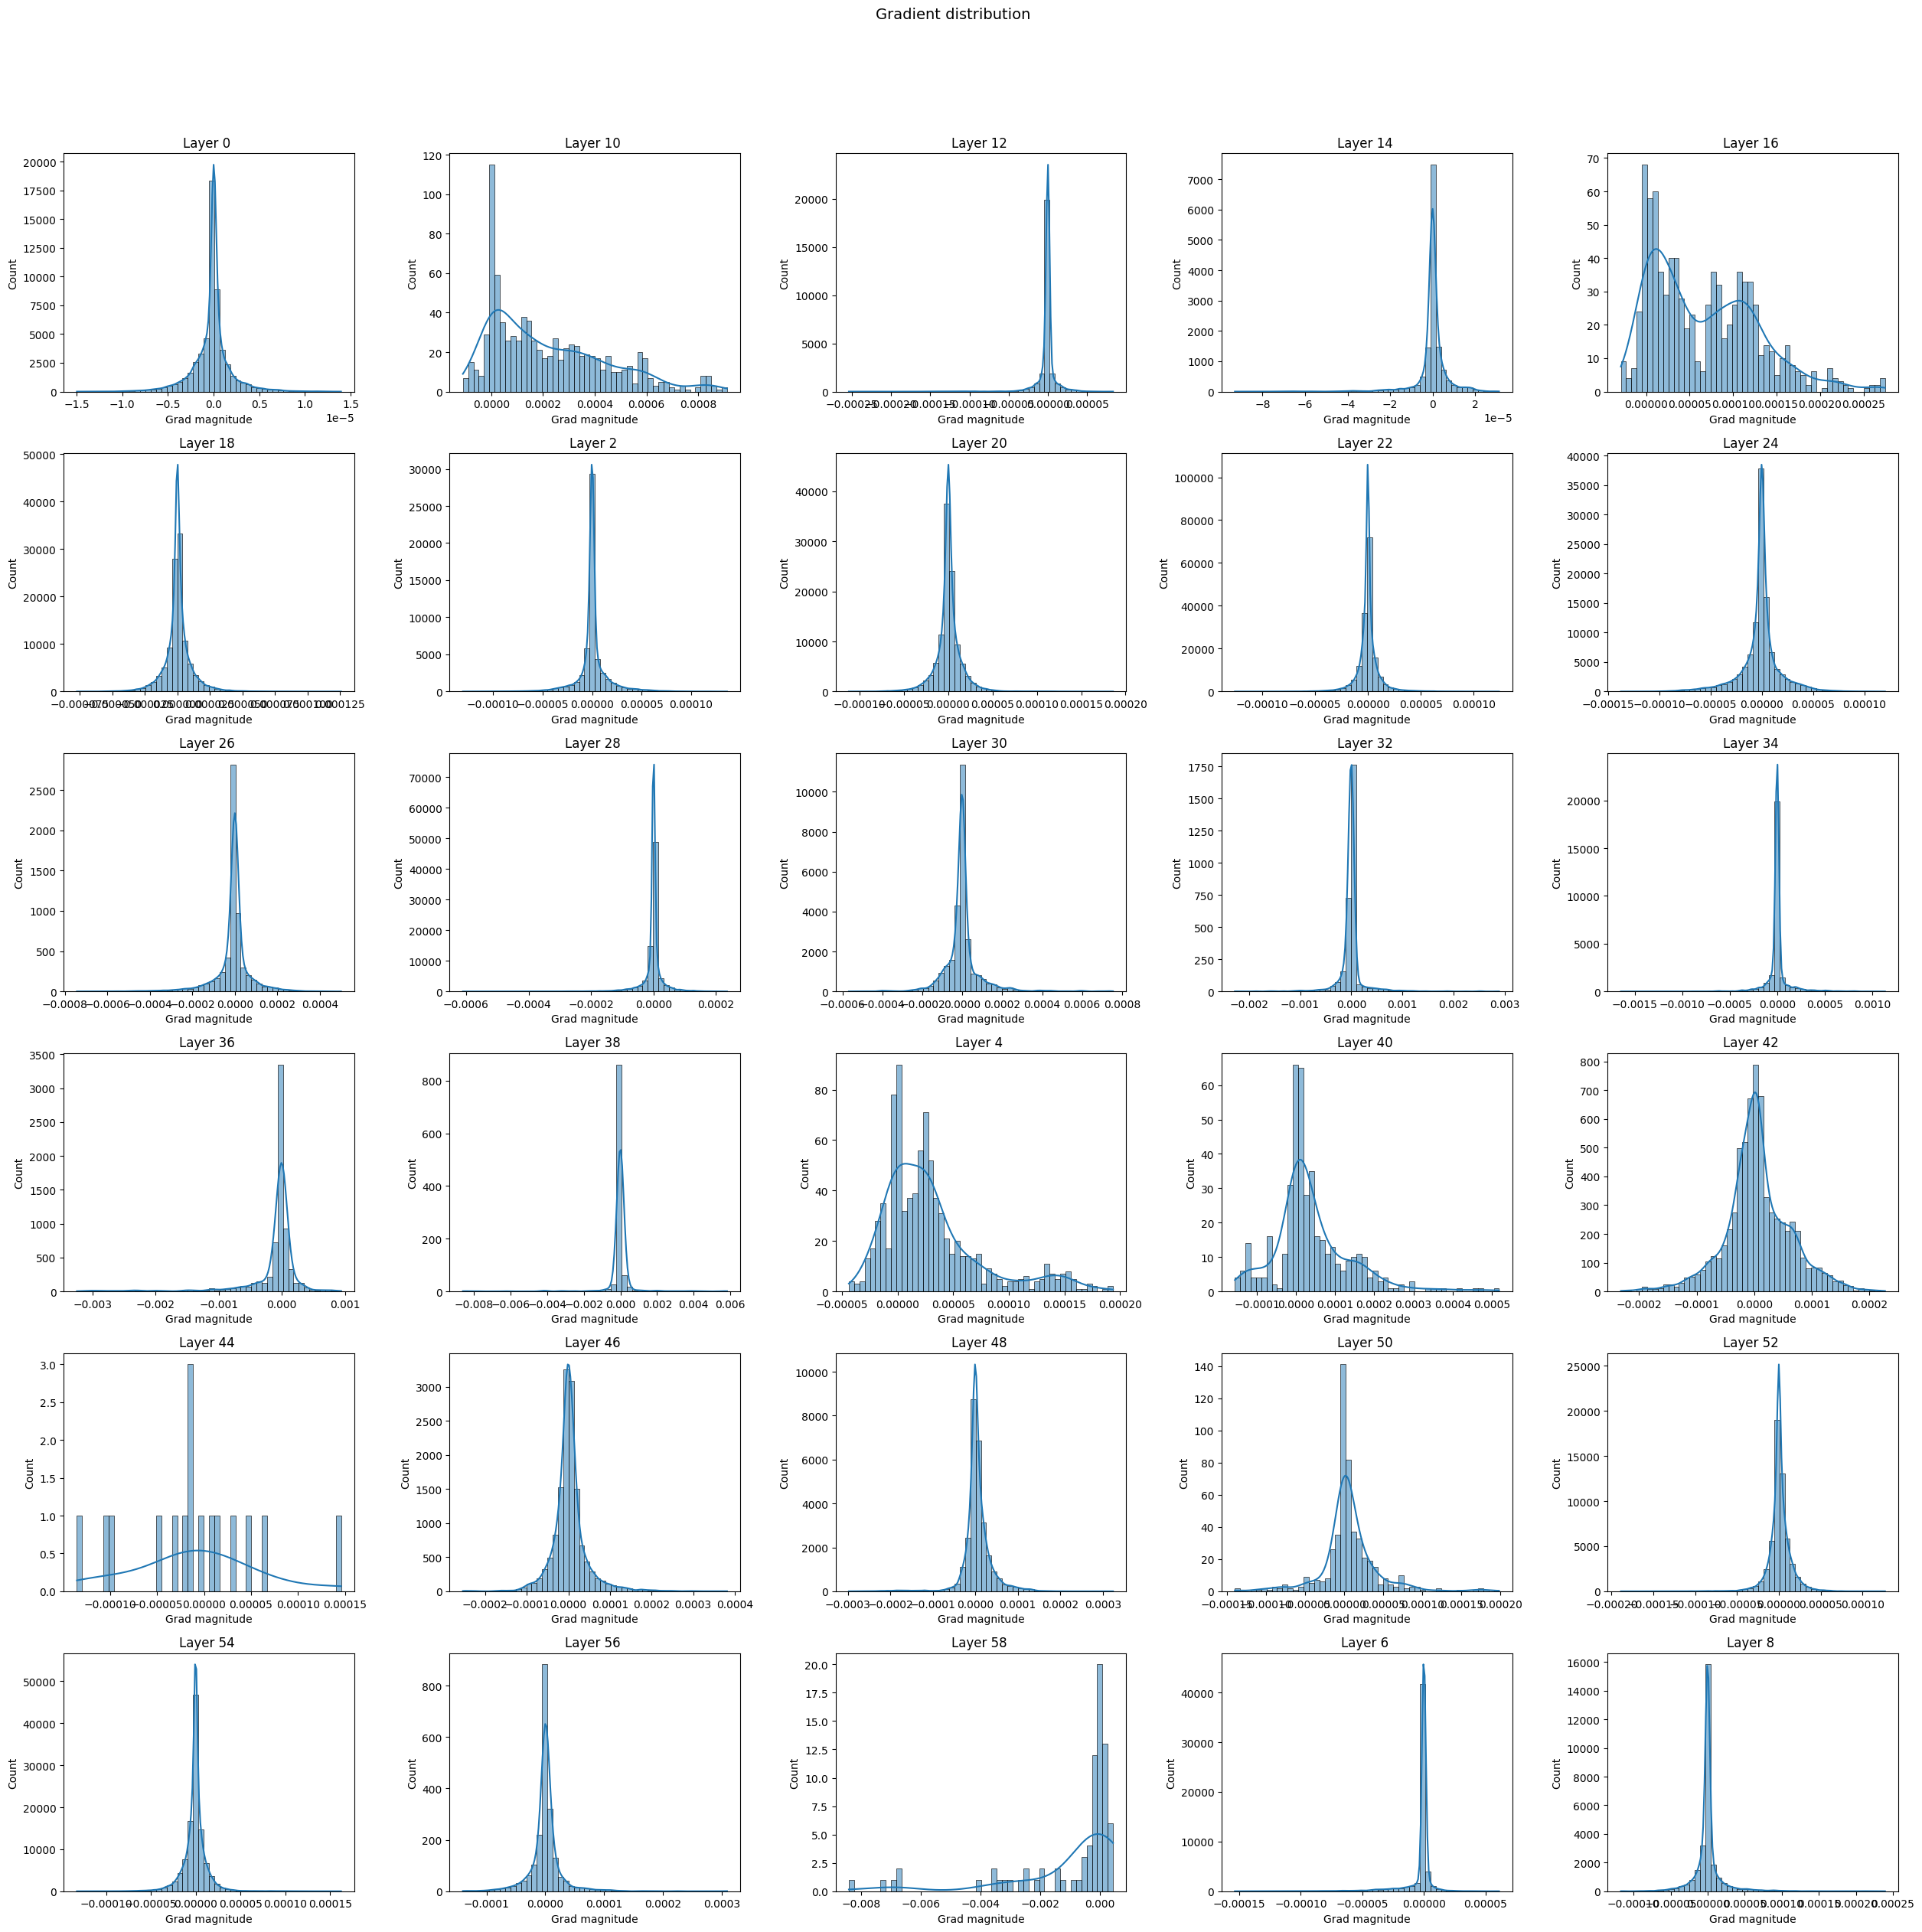

Layer 0 - Variance: 4.54803902871781e-12
Layer 10 - Variance: 5.050907603276755e-08
Layer 12 - Variance: 2.535748278020833e-10
Layer 14 - Variance: 7.415670855159817e-11
Layer 16 - Variance: 3.725129982257158e-09
Layer 18 - Variance: 1.1354242546168791e-10
Layer 2 - Variance: 2.790126185647779e-10
Layer 20 - Variance: 2.391244147137428e-10
Layer 22 - Variance: 1.2482249955869662e-10
Layer 24 - Variance: 3.814318305650488e-10
Layer 26 - Variance: 7.561267167943697e-09
Layer 28 - Variance: 1.5161104593985897e-09
Layer 30 - Variance: 9.139184520279287e-09
Layer 32 - Variance: 6.583874068155637e-08
Layer 34 - Variance: 1.7729780310560272e-08
Layer 36 - Variance: 2.0358848473733815e-07
Layer 38 - Variance: 5.823592914566689e-07
Layer 4 - Variance: 1.9419563734857093e-09
Layer 40 - Variance: 9.560561231580778e-09
Layer 42 - Variance: 3.283225913364163e-09
Layer 44 - Variance: 4.377858964232928e-09
Layer 46 - Variance: 1.8859482864286292e-09
Layer 48 - Variance: 1.1883390937938998e-09
Layer 5

In [80]:
visualize_gradients(state, state.params, color="C0", print_variance=True)